# Week 3 Kaggle Bicycle data modeling

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import  RidgeCV, LassoCV, ElasticNetCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.set_index(pd.to_datetime(df['datetime']), inplace = True)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


In [4]:
# split table into X table for variables and y for predicted variable
X = df.drop(columns = ['count', 'registered', 'casual'])
y = df['count']

In [5]:
# split into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [6]:
X_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour
datetime,,,,,,,,,,
2011-07-11 00:00:00,2011-07-11 00:00:00,3,0,1,1,28.70,32.575,65,12.9980,0
2012-05-18 22:00:00,2012-05-18 22:00:00,2,0,1,1,22.96,26.515,52,22.0028,22
2011-04-01 23:00:00,2011-04-01 23:00:00,2,0,1,1,12.30,15.910,61,6.0032,23
2012-09-16 09:00:00,2012-09-16 09:00:00,3,0,0,1,23.78,27.275,60,8.9981,9
2011-02-01 23:00:00,2011-02-01 23:00:00,1,0,1,3,8.20,9.850,93,12.9980,23


## Beginning feature engineering
- variables come as 
    - continous/ numerical 
    - categorical
    - 

In [7]:
def day_and_time_from_datetime(df):
    '''
    this helper function extracts hour, day, and month from the datetime column.
    
    Params:
    -------
    
    datetime-column of dataframe df
    '''
    df = df.copy()
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['weekday'] = pd.to_datetime(df['datetime']).dt.dayofweek
    df['month'] = pd.to_datetime(df['datetime']).dt.month
    df = df.drop('datetime', axis = 1)
    return df

In [8]:
## Feature engineering using above defined helper function

# features from the original datetime-column are extracted, onehot-encoded and defined as interaction-features
time_feat = ['datetime']
time_transformer = Pipeline(steps=[
    ('day_time_extract', FunctionTransformer(day_and_time_from_datetime)),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('polynomial', PolynomialFeatures(interaction_only=True, include_bias=False))
    ])

# the numeric parameterswindspeed and atemp are scaled to a mean-value of 0 and a variance of 1
numeric_features = ['windspeed', 'atemp']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ])

# categorical feature weather is onehot-encoded
categorical_features = ['weather']
categorical_transformer = Pipeline(steps=[   
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# two more interacting features are defined: (humidity and workingday) and (workingday and atemp), both are onehot-encoded afterwards
interact_features = ['humidity' ,'workingday']
interaction_transformer = Pipeline(steps=[
    ('polynomial', PolynomialFeatures(interaction_only = True, include_bias=False)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

interact_features3 = ['workingday' ,'atemp']
interaction_transformer3 = Pipeline(steps=[
    ('polynomial3', PolynomialFeatures(interaction_only = True, include_bias=False)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

# no features are included, which are not preprocessed
passthrough_features = []

In [9]:
# definition of the preprcessing column-transformer

preprocessor = ColumnTransformer(
    transformers=[
        ('day_time_extract', time_transformer, time_feat),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('polynomial', interaction_transformer, interact_features),
        ('polynomial3', interaction_transformer3, interact_features3)
        #('pass', 'passthrough', passthrough_features)
        ])

In [10]:
# Append classifier to preprocessing pipeline.
## Ridge-Regularization gave best values (see below), therefore it is chosen here

p = Pipeline(steps=[('preprocessor', preprocessor),
                    ('classifier', Ridge())
                    ])

In [11]:
# apply/ fit the pipeline to X_train & y_train; print some result-metrices

p.fit(X_train, y_train)
ypred_train = p.predict(X_train)
print('MSE: ' + str(mean_squared_error(y_train, ypred_train)))
print('MAE: ' + str(mean_absolute_error(y_train, ypred_train)))
print('r2: ' + str(r2_score(y_train, ypred_train)))

MSE: 5331.4012449878355
MAE: 53.278792513903525
r2: 0.83750103432238


Text(0.5, 1.0, 'mean cross validation score')

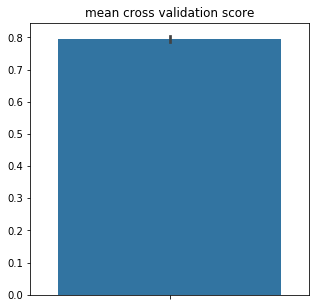

In [12]:
# cross validation and plotting the mean validation score

csv = cross_val_score(p, X_train, y_train, cv = 5, scoring = 'r2')
CSV = pd.DataFrame(csv)
plt.figure(figsize= (5,5))
sns.barplot(y = CSV)
plt.title('mean cross validation score')

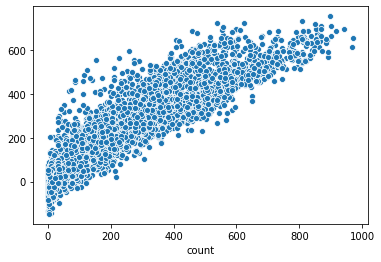

In [13]:
# plot the distribution of predicted and trained y-values (counts)

sns.scatterplot(y_train, ypred_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


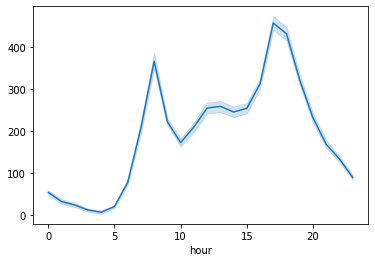

In [14]:
# to plot the model-prediction over the hour of the day, the hour needs to be extracted first from the datetime

X_train['hour'] = pd.to_datetime(X_train['datetime']).dt.hour
sns.lineplot(x=X_train['hour'], y = ypred_train)

In [15]:
# perform GridSearch to find the best CrossValidated model
##  define our hyperparameters to combine: Test CrossValidation for different models

param_grid = {
    'classifier' : [LinearRegression(), RidgeCV(), LassoCV(), ElasticNetCV()]
}
grid_search = GridSearchCV(p, param_grid)

In [16]:
# perform GridSearch, store in Dataframe

grid_search.fit(X_train, y_train) 
GS = pd.DataFrame(grid_search.cv_results_)
GS

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.223034,0.016572,0.026677,0.000725,"LinearRegression(copy_X=True, fit_intercept=Tr...","{'classifier': LinearRegression(copy_X=True, f...",0.770670,0.786762,0.806225,0.802665,0.788326,0.790930,0.012699,3
1,2.166865,0.145490,0.027231,0.001164,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]), cv=N...","{'classifier': RidgeCV(alphas=array([ 0.1, 1....",0.775131,0.791667,0.808209,0.806234,0.791588,0.794566,0.011977,1
2,43.179738,2.052276,0.032793,0.004350,"LassoCV(alphas=None, copy_X=True, cv=None, eps...","{'classifier': LassoCV(alphas=None, copy_X=Tru...",0.772271,0.792012,0.807354,0.801115,0.790627,0.792676,0.011897,2
3,15.580195,0.562845,0.031559,0.006893,"ElasticNetCV(alphas=None, copy_X=True, cv=None...","{'classifier': ElasticNetCV(alphas=None, copy_...",0.485129,0.521793,0.499234,0.508747,0.501290,0.503239,0.012020,4


In [17]:
# wrangle with the datafram from GridSearch-Results for plotting

GS2 = GS.stack() 
GS3 = GS2.unstack(0).reset_index()
GS4 = GS3.iloc[6:11]
GS4.rename(columns = {'index' :'index',  0:'LinReg', 1: 'RidgeCV', 2: 'LassoCV', 3:'ElasticNetCV'}, inplace =True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0.5, 1.0, 'r2-score model cross validation')

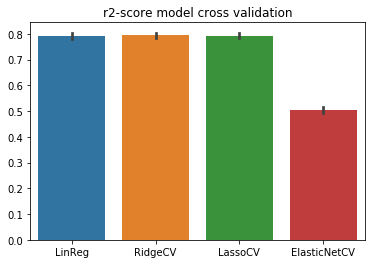

In [18]:
# plot performance of the models from GridSearch

sns.barplot(data = GS4) 
plt.title('r2-score model cross validation')

Text(0.5, 1.0, 'mean fit time')

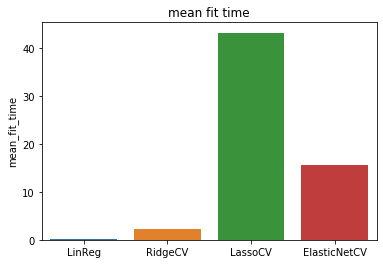

In [19]:
# plot time-usage of the models from GridSearch

GS_label = ['LinReg', 'RidgeCV', 'LassoCV', 'ElasticNetCV'] 
sns.barplot(y = 'mean_fit_time', x = GS_label, data = GS)
plt.title('mean fit time')

### apply the derived model to the test-dataset
- output the same result-matrices and
- the distribution of predicted and test y-values (counts)
- together with the perdicted count-values distributed over the hours of a day

In [20]:
ypred_test = p.predict(X_test) # taking the model to the test data
print('MSE: ' + str(mean_squared_error(ypred_test, y_test)))
print('MAE: ' + str(mean_absolute_error(ypred_test, y_test)))
print('r2: ' + str(r2_score(ypred_test, y_test)))

MSE: 6624.832677804829
MAE: 59.4016524467677
r2: 0.7439672691660693


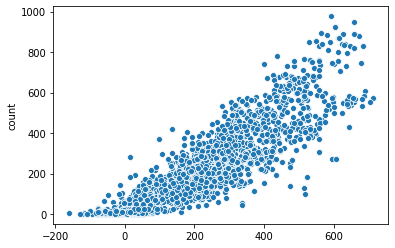

In [21]:
sns.scatterplot(ypred_test, y_test)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


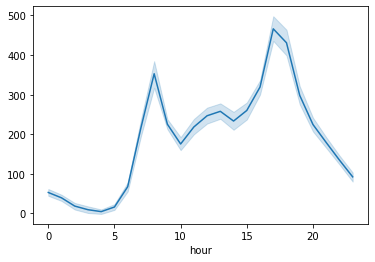

In [23]:
X_test['hour'] = pd.to_datetime(X_test['datetime']).dt.hour
sns.lineplot(x=X_test['hour'], y = ypred_test)